In [29]:
# Necessary Dependencies
import numpy as np
import pandas as pd
!pip install utils
from utils import *
from glob import glob
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from datetime import datetime
import statistics
from tqdm import tqdm
import tensorflow as tf
# DenseNet Dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, VGG16, ResNet50
from keras import backend as K
from tensorflow.keras import Sequential
import keras
import matplotlib
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import roc_curve, auc
print('Started')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Started


# Load & Split Data

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator for training and validation with validation split
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Define validation split here, not "subset"
)

# Initialize ImageDataGenerator for test data (no split needed)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/labeled-chest-xray-images/chest_xray/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset="training"  # Define subset here for training
)

# Create validation data generator
valid_generator = train_datagen.flow_from_directory(
    '/kaggle/input/labeled-chest-xray-images/chest_xray/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset="validation"  # Define subset here for validation
)

# Create test data generator
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/labeled-chest-xray-images/chest_xray/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# View some semples

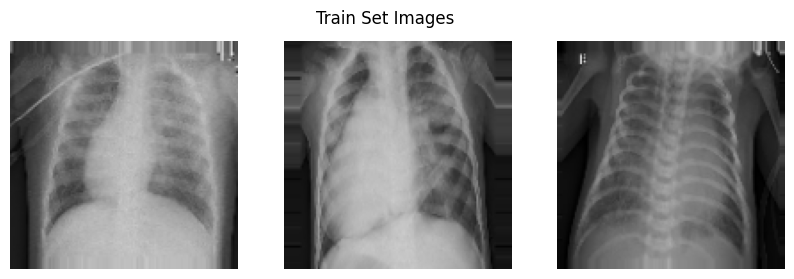

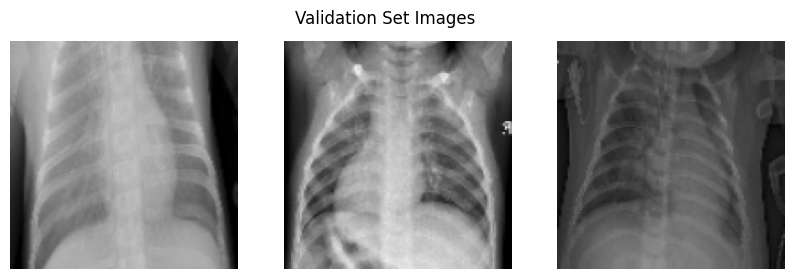

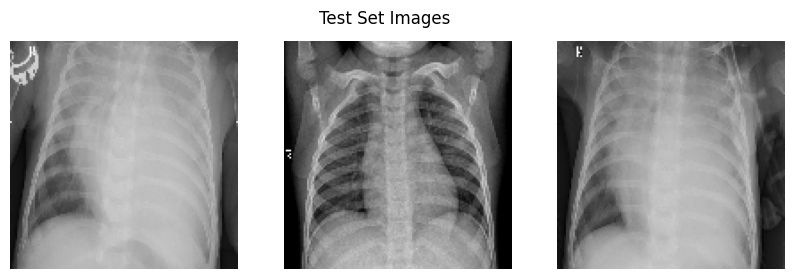

In [33]:
# view some semples
import matplotlib.pyplot as plt

def plot_images(generator, title):
  """Plots 3 images from a generator in a row."""
  x, y = next(generator)
  fig, axes = plt.subplots(1, 3, figsize=(10, 3))
  fig.suptitle(title, fontsize=12)
  for i in range(3):
    axes[i].imshow(x[i])
    axes[i].axis('off')
  plt.show()

plot_images(train_generator, "Train Set Images")
plot_images(valid_generator, "Validation Set Images")
plot_images(test_generator, "Test Set Images")


# CallBackes

In [34]:
def get_callbacks(model_name):
    callbacks =[]

    # Change the file extension to '.keras'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.keras',
                                                    verbose=1,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)
    callbacks.append(checkpoint)
    #--------------------------------------------------------
    anne = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.5,
                             patience=5,
                             verbose=2,
                             min_lr=0.0000001,
                             min_delta=0.00001,
                             mode='auto')
    callbacks.append(anne)
    #--------------------------------------------------------
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=10)
    callbacks.append(earlystop)

    return callbacks

# Xception Model
## Compile Model
## Train Model

In [38]:
# Xception Model

base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape= (128,128,3),
    include_top=False
)

base_model.trainable = True

# Add classification head
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),        # Flatten
  tf.keras.layers.Dense(2, activation='sigmoid')   # Last layer
])

#----------------------------------------------------
# Model Complie
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#----------------------------------------------------
epochs = 50
callbacks = get_callbacks('Xception')
history = model.fit(
                train_generator,
                validation_data=valid_generator,
                epochs=epochs,
                callbacks=callbacks
                )

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9043 - loss: 0.2427
Epoch 1: val_loss improved from inf to 0.26005, saving model to model.Xception.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 109s 564ms/step - accuracy: 0.9045 - loss: 0.2422 - val_accuracy: 0.9569 - val_loss: 0.2600 - learning_rate: 0.0010
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9607 - loss: 0.1031
Epoch 2: val_loss improved from 0.26005 to 0.10643, saving model to model.Xception.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 453ms/step - accuracy: 0.9608 - loss: 0.1030 - val_accuracy: 0.9751 - val_loss: 0.1064 - learning_rate: 0.0010
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9755 - loss: 0.0755
Epoch 3: val_loss did not improve from 0.10643
131/131 ━━━━━━━━━━━━━━━━━━━━ 60s 439ms/step - accuracy: 0.9755 - loss: 0.0756 - val_accuracy: 0.8316 - val_loss: 2.6597 - learning_rate: 0.0010
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9621 - loss: 0.0944
Epoch

# view loss & Accuracy

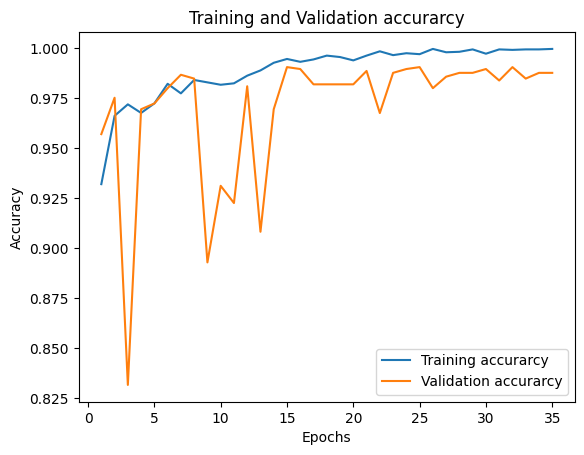

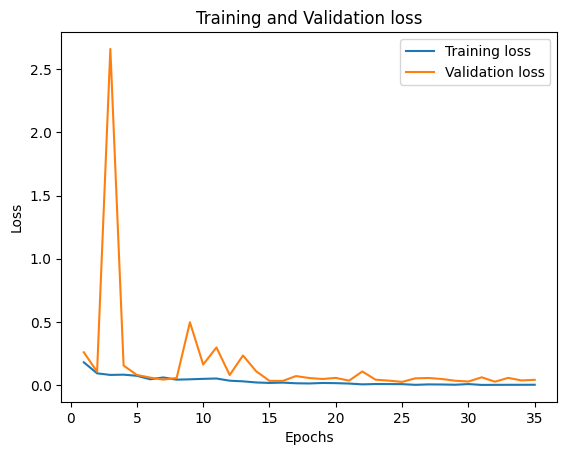

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best model

In [40]:
# load the DenseNet121 model

model = tf.keras.models.load_model('model.Xception.keras')

# Function to test Model

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the model (replace 'model.h5' with the actual path if different)
model = load_model('/kaggle/working/model.Xception.keras')

# Define the class labels (modify these according to your dataset)
class_labels = ["Normal", "Pneumonia"]

def predict_image_class(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0,1] if the model expects this

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]

    # Print and return the result
    print(f"Predicted Class: {predicted_class_label}")
    return predicted_class_label


In [45]:
predict_image_class('/kaggle/input/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-1031320-0001.jpeg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Class: Normal


'Normal'